# **Load Packages**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy  as np
import pandas as pd

import seaborn as sns
sns.set_style(style = 'darkgrid')

import matplotlib.pyplot as plt

from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.model_selection   import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics           import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.svm      import SVC
from sklearn.ensemble import RandomForestClassifier

# **Load Dataset**

In [ ]:
# Load Home Loan dataset
home_loan = pd.read_csv('Home Loan.csv', sep = ';')

In [3]:
print('Home Loan dataset:')
home_loan.head()

Home Loan dataset:


,Loan ID,Gender,Married,Dependents,Education,Self Employed,Applicant Income,Coapplicant Income,Loan Amount,Loan Amount Term,Credit History,Property Area,Loan Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,Good Credit History,Urban,Accepted
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Good Credit History,Rural,Not Accepted
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Good Credit History,Urban,Accepted
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Good Credit History,Urban,Accepted
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Good Credit History,Urban,Accepted


# **Data Exploration**

In [4]:
print('Information about dataset:')
home_loan.info()

Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loan ID             614 non-null    object 
 1   Gender              601 non-null    object 
 2   Married             611 non-null    object 
 3   Dependents          599 non-null    object 
 4   Education           614 non-null    object 
 5   Self Employed       582 non-null    object 
 6   Applicant Income    614 non-null    int64  
 7   Coapplicant Income  614 non-null    float64
 8   Loan Amount         592 non-null    float64
 9   Loan Amount Term    600 non-null    float64
 10  Credit History      564 non-null    object 
 11  Property Area       614 non-null    object 
 12  Loan Status         614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


In [5]:
home_loan_prep = home_loan.copy()

In [6]:
# Show distribution of values in the Loan Status column
print('Distribution of values:')

print(pd.concat([home_loan_prep['Loan Status'].value_counts().rename('Count'),
                 100 * home_loan_prep['Loan Status'].value_counts(normalize = True).rename('Percentage of Loan Status')],
                 axis = 1))

Distribution of values:
              Count  Percentage of Loan Status
Loan Status                                   
Accepted        422                  68.729642
Not Accepted    192                  31.270358


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Distribusi label <b>Accepted</b> dan <b>Not Accepted</b> diketahui <b>tidak seimbang</b>, dengan rasio kemunculan masing-masing sebesar <b>68.72%</b> untuk <b>label Accepted</b> dan <b>31.27%</b> untuk <b>label Not Accepted</b>.
</p>

In [7]:
# Show duplicate values in the dataset
duplicate_values = home_loan_prep.duplicated().sum()

print(f'The data contains {duplicate_values} duplicate values')

The data contains 0 duplicate values


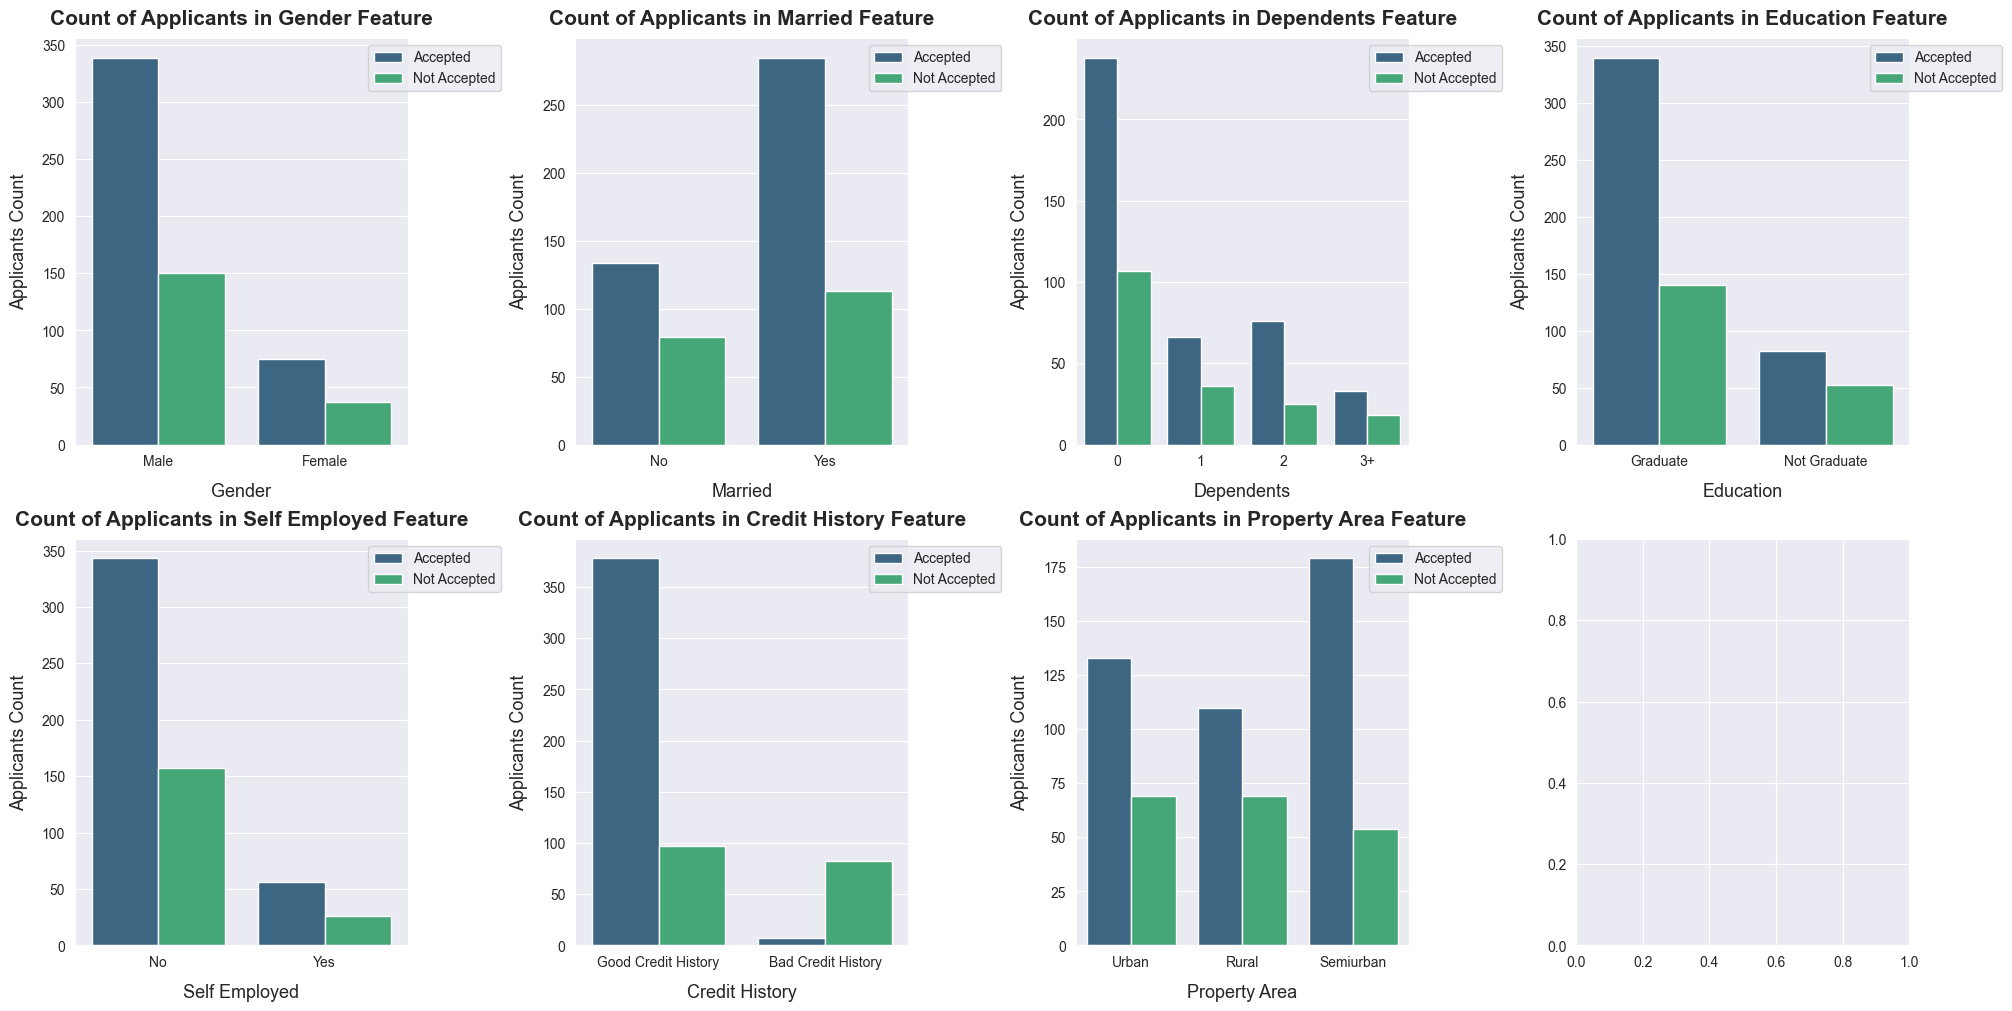

In [8]:
# Data exploration of categorical columns
column_names = ['Gender', 'Married', 'Dependents', 'Education', 'Self Employed', 'Credit History', 'Property Area']

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10), constrained_layout = True)

for ax, column in zip(axs.flatten(), column_names):
    sns.countplot(data = home_loan_prep, x = column, hue = 'Loan Status', palette = 'viridis', ax = ax)

    ax.set_title(f'Count of Applicants in {column} Feature', pad = 10, fontsize = 15, fontweight = 'bold')

    ax.set_xlabel(column            , labelpad = 10, fontsize = 13)
    ax.set_ylabel('Applicants Count', labelpad = 10, fontsize = 13)

    ax.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1), fontsize = 10)

plt.show()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan visualisasi, terdapat tujuh fitur utama yang dianalisis dalam kaitannya dengan status pinjaman, yaitu <b>Gender</b>, <b>Married</b>, <b>Dependents</b>, <b>Education</b>, <b>Self Employed</b>, <b>Credit History</b>, dan <b>Property Area</b>. Secara umum, label <b>Accepted</b> lebih dominan dibandingkan <b>Not Accepted</b> pada sebagian besar fitur. Pada fitur <b>Gender</b>, pria lebih sering mendapatkan persetujuan pinjaman dibandingkan wanita. Sementara itu, pada fitur <b>Married</b>, peminjam yang sudah menikah lebih banyak disetujui dibandingkan yang belum menikah. Untuk fitur <b>Dependents</b>, peminjam tanpa tanggungan mendominasi kategori <b>Accepted</b>, sedangkan semakin banyak tanggungan cenderung menurunkan peluang persetujuan. Pada fitur <b>Education</b>, lulusan perguruan tinggi (<b>Graduate</b>) lebih sering memperoleh persetujuan pinjaman dibandingkan yang tidak lulus. Sementara itu, pada fitur <b>Self Employed</b>, peminjam yang bekerja sebagai karyawan lebih banyak mendapatkan persetujuan dibandingkan yang bekerja mandiri.
</p>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Fitur paling signifikan adalah <b>Credit History</b>, di mana riwayat kredit yang baik sangat berpengaruh terhadap persetujuan pinjaman. Sementara itu, pada <b>Property Area</b>, peminjam dari wilayah <b>semi-urban</b> memiliki tingkat persetujuan tertinggi, diikuti wilayah <b>urban</b> dan <b>rural</b>.
</p>

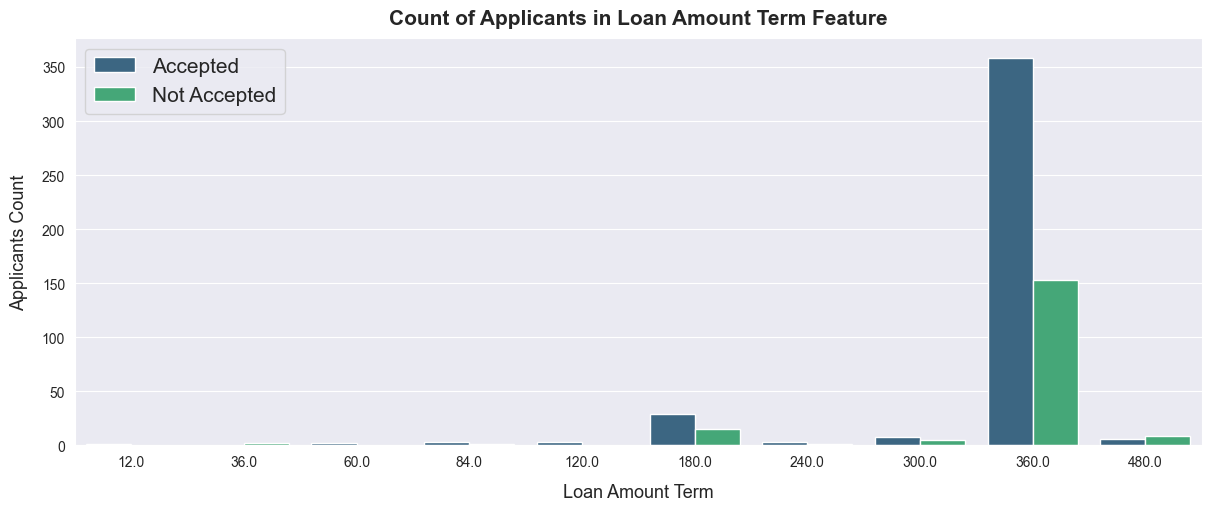

In [9]:
# Data exploration of Loan Amount Term column
plt.figure(figsize = (12, 5), constrained_layout = True)

sns.countplot(data = home_loan_prep, x = 'Loan Amount Term', hue = 'Loan Status', palette = 'viridis')

plt.title('Count of Applicants in Loan Amount Term Feature', pad = 10, size = 15, fontweight = 'bold')

plt.xlabel('Loan Amount Term', labelpad = 10, size = 13)
plt.ylabel('Applicants Count', labelpad = 10, size = 13)

plt.legend(loc = 'upper left', prop = {'size': 15})

plt.show()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan visualisasi fitur <b>Loan Amount Term</b>, peminjam dengan jangka waktu pinjaman <b>360 hari</b> cenderung lebih banyak diterima dibandingkan tidak diterima, diikuti oleh jangka waktu <b>180 hari</b> di posisi kedua. Sementara itu, jangka waktu lainnya memiliki jumlah peminjam yang sangat kecil.
</p>

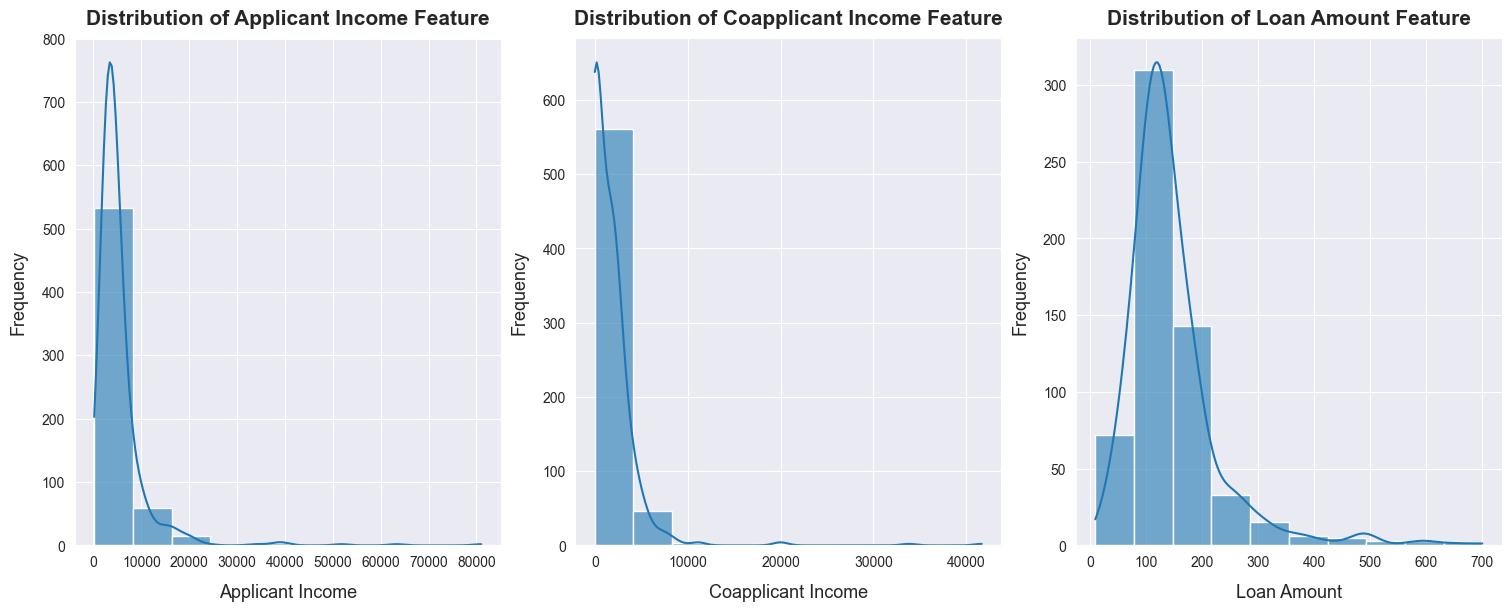

In [10]:
# Data exploration of numerical columns
column_names = ['Applicant Income', 'Coapplicant Income', 'Loan Amount']

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 6), constrained_layout = True)

for ax, column in zip(axs, column_names):
    sns.histplot(data = home_loan_prep, x = column, bins = 10, kde = True, alpha = 0.6, ax = ax)

    ax.set_title(f'Distribution of {column} Feature', pad = 10, fontsize = 15, fontweight = 'bold')

    ax.set_xlabel(column     , labelpad = 10, fontsize = 13)
    ax.set_ylabel('Frequency', labelpad = 10, fontsize = 13)

plt.show()

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan visualisasi distribusi fitur <b>Applicant Income</b>, <b>Coapplicant Income</b>, dan <b>Loan Amount</b>, terlihat bahwa ketiga variabel memiliki distribusi yang <b>sangat condong ke kanan (skewed right)</b>. Mayoritas peminjam memiliki <b>Applicant Income</b> yang relatif rendah, dengan frekuensi tertinggi berada di kisaran pendapatan rendah, sementara hanya sedikit pemohon dengan pendapatan yang sangat tinggi. <b>Coapplicant Income</b> juga menunjukkan pola serupa, dengan sebagian besar pemohon memiliki penghasilan yang rendah atau bahkan nol, yang menunjukkan bahwa banyak peminjam yang mengajukan pinjaman tanpa coapplicant.
</p>

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Sementara itu, fitur <b>Loan Amount</b> juga memiliki distribusi yang mirip, di mana mayoritas pinjaman berada di kisaran jumlah rendah hingga menengah, dengan sedikit peminjam yang mengajukan pinjaman dalam jumlah besar. Pola distribusi ini menunjukkan bahwa sebagian besar peminjam berada dalam kelompok pendapatan rendah hingga menengah dan jumlah pinjaman yang diajukan cenderung mengikuti pola ini.
</p>

# **Data Preparation**

In [11]:
# Create a function to show the number of missing values
def display_missing(dataframe):
    for column in dataframe.columns.tolist():
        print(f'Number of missing values in the {column} feature is {dataframe[column].isnull().sum()}')

In [12]:
# Show the number of missing values in each column
print('Number of missing values before imputation:')
display_missing(home_loan_prep)

Number of missing values before imputation:
Number of missing values in the Loan ID feature is 0
Number of missing values in the Gender feature is 13
Number of missing values in the Married feature is 3
Number of missing values in the Dependents feature is 15
Number of missing values in the Education feature is 0
Number of missing values in the Self Employed feature is 32
Number of missing values in the Applicant Income feature is 0
Number of missing values in the Coapplicant Income feature is 0
Number of missing values in the Loan Amount feature is 22
Number of missing values in the Loan Amount Term feature is 14
Number of missing values in the Credit History feature is 50
Number of missing values in the Property Area feature is 0
Number of missing values in the Loan Status feature is 0


In [13]:
# Handle missing values in columns with category data type
column_names = ['Gender', 'Married', 'Dependents', 'Self Employed', 'Credit History', 'Loan Amount Term']

for column in column_names:
    home_loan_prep[column] = home_loan_prep[column].fillna(home_loan_prep[column].mode()[0])

In [14]:
# Handle missing values in columns with numeric data type
home_loan_prep['Loan Amount'] = home_loan_prep['Loan Amount'].fillna(home_loan_prep['Loan Amount'].median())

In [15]:
print('Number of missing values after imputation:')
display_missing(home_loan_prep)

Number of missing values after imputation:
Number of missing values in the Loan ID feature is 0
Number of missing values in the Gender feature is 0
Number of missing values in the Married feature is 0
Number of missing values in the Dependents feature is 0
Number of missing values in the Education feature is 0
Number of missing values in the Self Employed feature is 0
Number of missing values in the Applicant Income feature is 0
Number of missing values in the Coapplicant Income feature is 0
Number of missing values in the Loan Amount feature is 0
Number of missing values in the Loan Amount Term feature is 0
Number of missing values in the Credit History feature is 0
Number of missing values in the Property Area feature is 0
Number of missing values in the Loan Status feature is 0


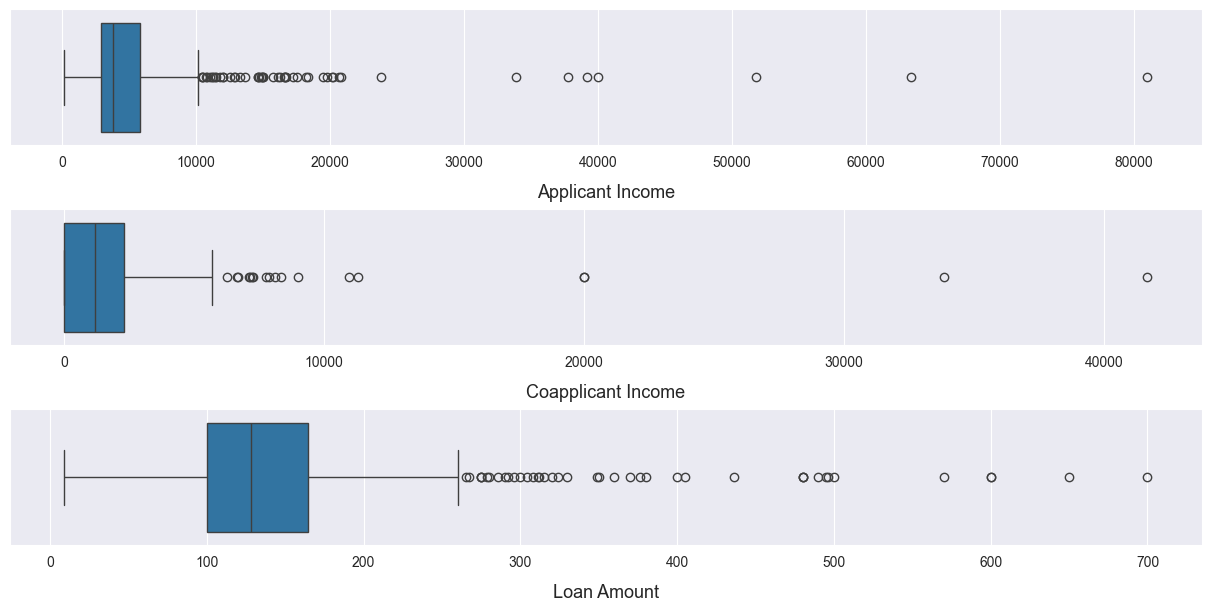

In [16]:
# Detecting outliers in the dataset using boxplot visualization
column_names = ['Applicant Income', 'Coapplicant Income', 'Loan Amount']

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 6), constrained_layout = True)

for ax, column in zip(axs.flatten(), column_names):
    sns.boxplot(data = home_loan_prep, x = column, ax = ax)

    ax.set_xlabel(column, labelpad = 10, fontsize = 13)

plt.show()

In [17]:
# Handle outliers in the dataset
column_names = ['Applicant Income', 'Coapplicant Income', 'Loan Amount']

for column in column_names:
    # Calculating IQR
    Q1 = home_loan_prep[column].quantile(0.25)
    Q3 = home_loan_prep[column].quantile(0.75)

    IQR = Q3 - Q1

    upper_bound = Q3 + (1.5 * IQR)
    lower_bound = Q1 - (1.5 * IQR)

    # Handle outliers
    home_loan_prep[column] = home_loan_prep[column].mask(home_loan_prep[column] < lower_bound, lower_bound)
    home_loan_prep[column] = home_loan_prep[column].mask(home_loan_prep[column] > upper_bound, upper_bound)

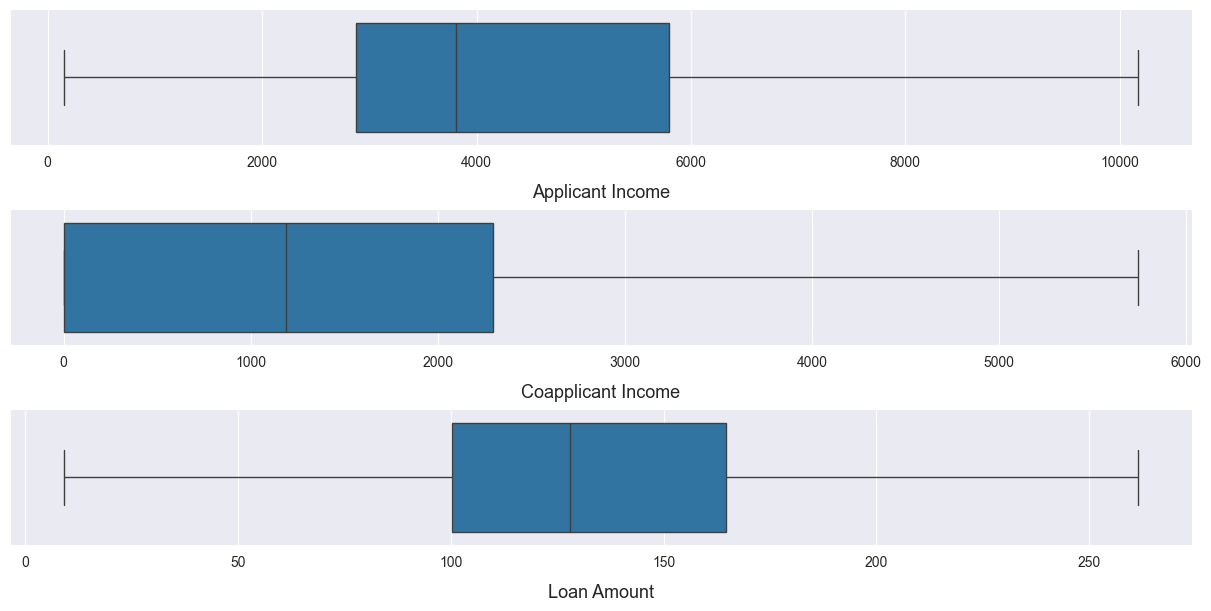

In [18]:
# Detecting outliers in the dataset using boxplot visualization after handling
column_names = ['Applicant Income', 'Coapplicant Income', 'Loan Amount']

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 6), constrained_layout = True)

for ax, column in zip(axs.flatten(), column_names):
    sns.boxplot(data = home_loan_prep, x = column, ax = ax)

    ax.set_xlabel(column, labelpad = 10, fontsize = 13)

plt.show()

In [19]:
# Perform feature engineering by adding a new column called Loan Amount Term Binned
def loan_amount_term_transformation(term):
    if term < 120:
        return 'Short-term Loans'

    if term >= 120 and term < 300:
        return 'Medium-term Loans'

    if term >= 360:
        return 'Long-term Loans'

home_loan_prep['Loan Amount Term Binned'] = home_loan_prep['Loan Amount Term'].map(loan_amount_term_transformation)

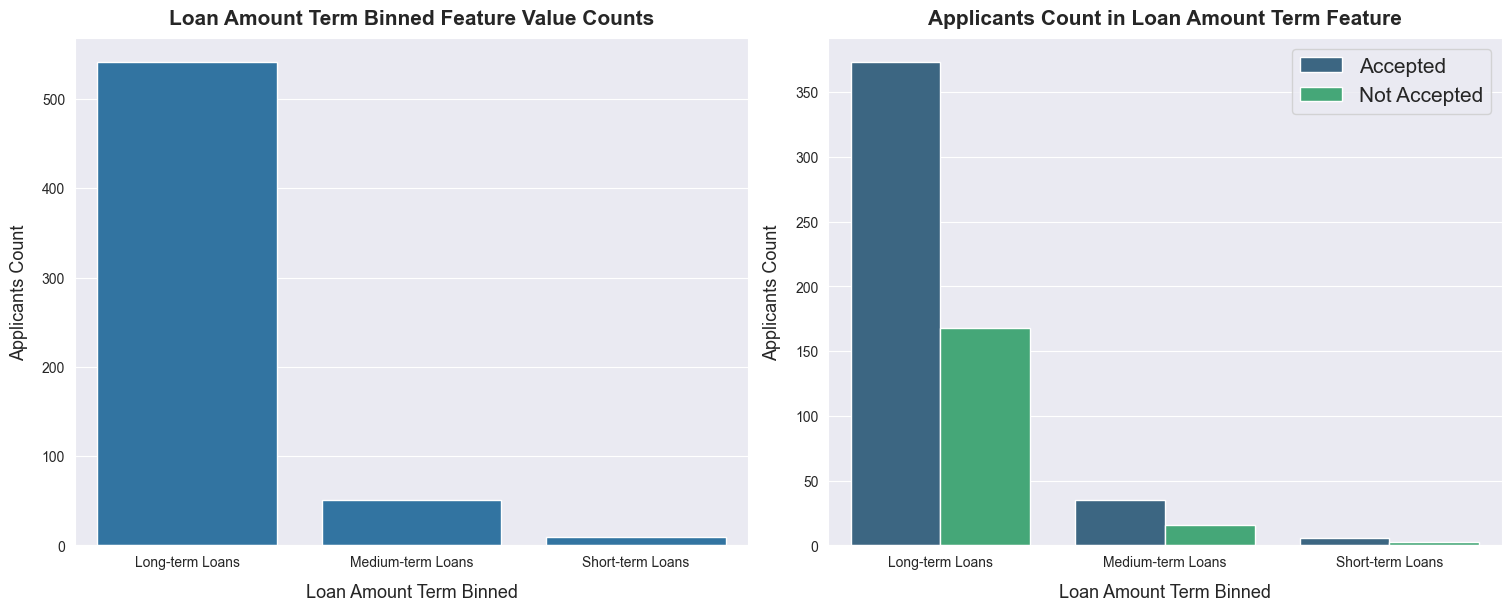

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6), constrained_layout = True)

# Show barplot visualization for Loan Amount Term Binned column
sns.barplot(x = home_loan_prep['Loan Amount Term Binned'].value_counts().index, y = home_loan_prep['Loan Amount Term Binned'].value_counts().values,
            ax = axs[0])

axs[0].set_title('Loan Amount Term Binned Feature Value Counts', pad = 10, fontsize = 15, fontweight = 'bold')

axs[0].set_xlabel('Loan Amount Term Binned', labelpad = 10, fontsize = 13)
axs[0].set_ylabel('Applicants Count'       , labelpad = 10, fontsize = 13)

# Show countplot visualization for Loan Amount Term Binned column
sns.countplot(data = home_loan_prep, x = 'Loan Amount Term Binned', hue = 'Loan Status', palette = 'viridis', ax = axs[1])

axs[1].set_title('Applicants Count in Loan Amount Term Feature', pad = 10, fontsize = 15, fontweight = 'bold')

axs[1].set_xlabel('Loan Amount Term Binned', labelpad = 10, size = 13)
axs[1].set_ylabel('Applicants Count'       , labelpad = 10, size = 13)

axs[1].legend(loc = 'upper right', prop = {'size': 15})

plt.show()

In [21]:
home_loan_prep['Loan Status'] = home_loan_prep['Loan Status'].replace(to_replace = {'Accepted': 1, 'Not Accepted': 0})

In [22]:
# Delete unnecessary column
home_loan_prep = home_loan_prep.drop(['Loan ID', 'Loan Amount Term'], axis = 1)

In [23]:
print('Updated Home Loan dataset:')
home_loan_prep.head()

Updated Home Loan dataset:


,Gender,Married,Dependents,Education,Self Employed,Applicant Income,Coapplicant Income,Loan Amount,Credit History,Property Area,Loan Status,Loan Amount Term Binned
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,Good Credit History,Urban,1,Long-term Loans
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,Good Credit History,Rural,0,Long-term Loans
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,Good Credit History,Urban,1,Long-term Loans
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,Good Credit History,Urban,1,Long-term Loans
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,Good Credit History,Urban,1,Long-term Loans


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Fitur-fitur biner, seperti Gender, Married, Education, Self Employed, dan Credit History, akan dikonversi menjadi format yang dapat dipahami oleh model. Untuk fitur-fitur ini, teknik <b>LabelEncoder</b> akan diterapkan. Sementara itu, fitur-fitur dengan lebih dari dua kategori, seperti Dependents, Property Area, dan Loan Amount Term Binned, akan diproses menggunakan teknik <b>One Hot Encoding</b>.
</p>

In [24]:
column_names = ['Gender', 'Married', 'Dependents', 'Education', 'Self Employed', 'Credit History', 'Property Area', 'Loan Amount Term Binned']

labelers = {}
column_cat_non_binary = []

# Perform data transformation using LabelEncoder
for column in column_names:
    if len(home_loan_prep[column].unique()) == 2:
        labelers[column] = LabelEncoder()

        home_loan_prep[column] = labelers[column].fit_transform(home_loan_prep[column])
    else:
        column_cat_non_binary.append(column)

# Perform data transformation using One Hot Encoding
home_loan_prep = pd.get_dummies(home_loan_prep, columns = column_cat_non_binary, dtype = 'int')

In [25]:
y = home_loan_prep.pop('Loan Status').to_numpy()

In [26]:
print('The latest Home Loan dataset:')
home_loan_prep.head()

The latest Home Loan dataset:


,Gender,Married,Education,Self Employed,Applicant Income,Coapplicant Income,Loan Amount,Credit History,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property Area_Rural,Property Area_Semiurban,Property Area_Urban,Loan Amount Term Binned_Long-term Loans,Loan Amount Term Binned_Medium-term Loans,Loan Amount Term Binned_Short-term Loans
0,1,0,0,0,5849.0,0.0,128.0,1,1,0,0,0,0,0,1,1,0,0
1,1,1,0,0,4583.0,1508.0,128.0,1,0,1,0,0,1,0,0,1,0,0
2,1,1,0,1,3000.0,0.0,66.0,1,1,0,0,0,0,0,1,1,0,0
3,1,1,1,0,2583.0,2358.0,120.0,1,1,0,0,0,0,0,1,1,0,0
4,1,0,0,0,6000.0,0.0,141.0,1,1,0,0,0,0,0,1,1,0,0


In [27]:
X = home_loan_prep.to_numpy()

In [28]:
# Standardize the data using MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)

# **Data Modeling**

In [29]:
# Separate training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.2, random_state = 42)

print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}\n')

print(f'Shape of X_test  : {X_test.shape}')
print(f'Shape of y_test  : {y_test.shape}')

Shape of X_train : (491, 18)
Shape of y_train : (491,)

Shape of X_test  : (123, 18)
Shape of y_test  : (123,)


<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Dua model machine learning, <b>Support Vector Machine (SVM)</b> dan <b>Random Forest Classifier</b>, akan digunakan untuk melakukan klasifikasi pada dataset yang memiliki distribusi label tidak seimbang (imbalance). Karena ketidakseimbangan distribusi ini, metrik evaluasi yang digunakan untuk menentukan model terbaik adalah <b>F1-Score</b>, yang merupakan harmonic mean antara precision dan recall. F1-Score dipilih karena mampu memberikan penilaian yang lebih adil terhadap performa model dalam menangani kelas minoritas dibandingkan metrik seperti akurasi, yang dapat memberikan hasil bias pada dataset yang tidak seimbang. Setelah model dilatih dan dievaluasi, model dengan nilai F1-Score tertinggi akan dipilih sebagai model terbaik.
</p>

## **Support Vector Machine**

In [30]:
# Build a base model using Support Vector Machine
fold = KFold(n_splits = 5, shuffle = True, random_state = 53) # Setting up cross validation

# Build a model
clf_svm = SVC()

clf_svm.fit(X_train, y_train)

# Show the model evaluation on training dataset
svm_training_score = cross_val_score(clf_svm, X_train, y_train, scoring = 'f1', cv = fold)

print(f'F1-Score on training dataset : {100 * svm_training_score.mean():.2f}%')
print(f'Error    on training dataset : {svm_training_score.std()       :.3f}')

F1-Score on training dataset : 88.04%
Error    on training dataset : 0.018


In [31]:
# Calculate the model prediction
y_pred = clf_svm.predict(X_test)

# Show the model evaluation on testing dataset
svm_testing_score  = f1_score(y_test, y_pred)

print(f'F1-Score on testing dataset : {100 * svm_testing_score:.2f}%')

F1-Score on testing dataset : 85.87%



------------------ Classification Report -------------------

              precision    recall  f1-score   support

Not Accepted       0.95      0.42      0.58        43
    Accepted       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


--------------------- Confusion Matrix ---------------------



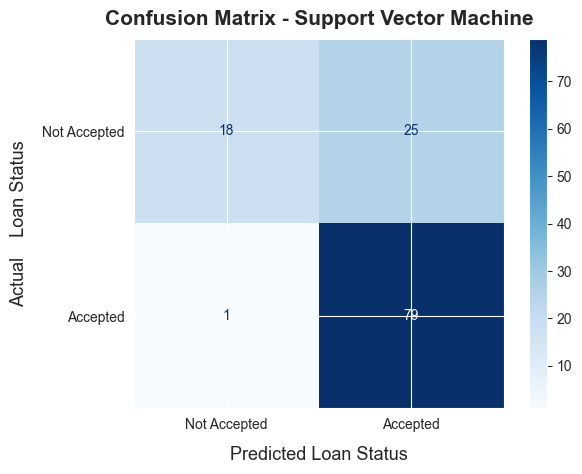

In [32]:
# Show the classification report
target_names = ['Not Accepted', 'Accepted']

print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, y_pred, target_names = target_names))

# Show the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)

plt.title('Confusion Matrix - Support Vector Machine', pad = 10, size = 15, fontweight = 'bold')

plt.xlabel('Predicted Loan Status', labelpad = 10, size = 13)
plt.ylabel('Actual    Loan Status', labelpad = 10, size = 13)

plt.show()

In [33]:
# Define the grid
C     = np.logspace(start = 0, stop =  10, num = 11)
gamma = np.logspace(start = 0, stop = -10, num = 11)

random_search = {
    'C'      : C,
    'kernel' : ['rbf', 'poly'],
    'gamma'  : gamma.tolist() + ['scale', 'auto']
}

In [34]:
# Perform hyperparameter tuning on the Support Vector Machine
fold = KFold(n_splits = 5, shuffle = True, random_state = 42) # Setting up cross validation

clf_svm = SVC()

clf_svm_tuned = RandomizedSearchCV(estimator = clf_svm, param_distributions = random_search, n_iter = 100, scoring = 'f1', cv = fold, 
                                   verbose = 0, random_state = 0)
clf_svm_tuned.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08, 1.e+09, 1.e+10]),
                                        'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001,
                                                  1e-05, 1e-06, 1e-07, 1e-08,
                                                  1e-09, 1e-10, 'scale',
                                                  'auto'],
                                        'kernel': ['rbf', 'poly']},
                   random_state=0, scoring='f1')

In [35]:
# Get the best hyperparameter
best_params = clf_svm_tuned.best_params_
best_model  = clf_svm_tuned.best_estimator_

In [36]:
# Evaluate the best model using Support Vector Machine
y_pred = best_model.predict(X_test)

# Show the best parameters
print('Best parameters')

for params, value in best_params.items():
    print(f'{params}\t: {value}')
print()

# Show the model evaluation after tuning parameters
svm_testing_score_tuned = f1_score(y_test, y_pred)

print(f'F1-Score on testing dataset after tuning parameters : {100 * svm_testing_score_tuned:.2f}%')

Best parameters
kernel	: rbf
gamma	: scale
C	: 1.0

F1-Score on testing dataset after tuning parameters : 85.87%



------------------ Classification Report -------------------

              precision    recall  f1-score   support

Not Accepted       0.95      0.42      0.58        43
    Accepted       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


--------------------- Confusion Matrix ---------------------



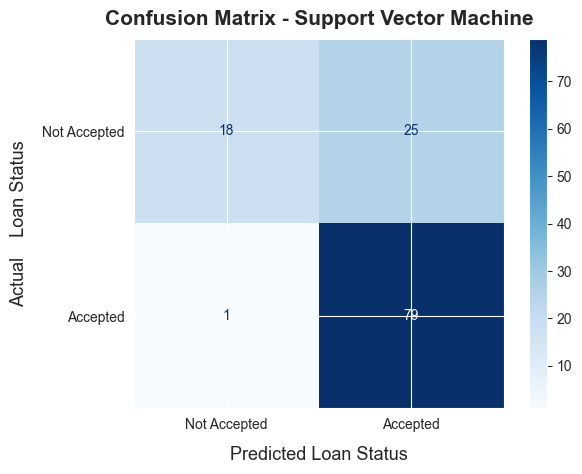

In [37]:
# Show the classification report
target_names = ['Not Accepted', 'Accepted']

print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, y_pred, target_names = target_names))

# Show the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)

plt.title('Confusion Matrix - Support Vector Machine', pad = 10, size = 15, fontweight = 'bold')

plt.xlabel('Predicted Loan Status', labelpad = 10, size = 13)
plt.ylabel('Actual    Loan Status', labelpad = 10, size = 13)

plt.show()

## **Random Forest Classifier**

In [38]:
# Build a base model using Random Forest Classifier
fold = KFold(n_splits = 5, shuffle = True, random_state = 53) # Setting up cross validation

# Build a model
clf_rf = RandomForestClassifier(criterion = 'entropy', random_state = 42)

clf_rf.fit(X_train, y_train)

# Show the model evaluation on training dataset
rf_training_score = cross_val_score(clf_rf, X_train, y_train, scoring = 'f1', cv = fold)

print(f'F1-Score on training dataset : {100 * rf_training_score.mean():.2f}%')
print(f'Error    on training dataset : {rf_training_score.std()       :.3f}')

F1-Score on training dataset : 86.12%
Error    on training dataset : 0.015


In [39]:
# Calculate the model prediction
y_pred = clf_rf.predict(X_test)

# Show the model evaluation on testing dataset
rf_testing_score  = f1_score(y_test, y_pred)

print(f'F1-Score on testing dataset : {100 * rf_testing_score:.2f}%')

F1-Score on testing dataset : 84.92%



------------------ Classification Report -------------------

              precision    recall  f1-score   support

Not Accepted       0.83      0.47      0.60        43
    Accepted       0.77      0.95      0.85        80

    accuracy                           0.78       123
   macro avg       0.80      0.71      0.72       123
weighted avg       0.79      0.78      0.76       123


--------------------- Confusion Matrix ---------------------



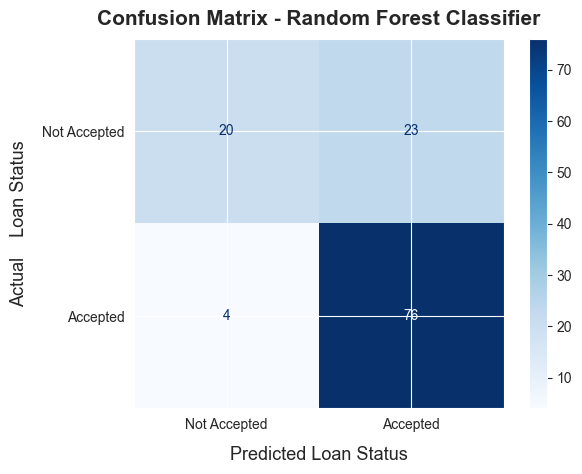

In [40]:
# Show the classification report
target_names = ['Not Accepted', 'Accepted']

print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, y_pred, target_names = target_names))

# Show the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)

plt.title('Confusion Matrix - Random Forest Classifier', pad = 10, size = 15, fontweight = 'bold')

plt.xlabel('Predicted Loan Status', labelpad = 10, size = 13)
plt.ylabel('Actual    Loan Status', labelpad = 10, size = 13)

plt.show()

In [41]:
# Define the grid
n_estimators = list(np.linspace(start = 200, stop = 2000, num = 100, dtype = np.int32))
max_features = ['auto', 'sqrt']

max_depth = list(np.linspace(start = 10, stop = 110, num = 11, dtype = np.int32))
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf  = [1, 2,  4]
bootstrap         = [True, False]

random_search = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap}

In [42]:
# Perform hyperparameter tuning on the Random Forest Classifier
fold = KFold(n_splits = 5, shuffle = True, random_state = 42) # Setting up cross validation

clf_rf = RandomForestClassifier(criterion = 'entropy', random_state = 42)

clf_rf_tuned = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_search, n_iter = 100, scoring = 'f1', cv = fold, 
                                   verbose = 0, random_state = 0)
clf_rf_tuned.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [np.int32(10),
                                                      np.int32(20),
                                                      np.int32(30),
                                                      np.int32(40),
                                                      np.int32(50),
                                                      np.int32(60),
                                                      np.int32(70),
                                                      np.int32(80),
                                                      np.int32(90),
                                                      np.int32(100),
                                                      np.int32(1...
                                                         np.int32(327),
                                                         np.int32(345),
                                                         np.int32(363),
                                                         np.int32(381),
                                                         np.int32(400),
                                                         np.int32(418),
                                                         np.int32(436),
                                                         np.int32(454),
                                                         np.int32(472),
                                                         np.int32(490),
                                                         np.int32(509),
                                                         np.int32(527),
                                                         np.int32(545),
                                                         np.int32(563),
                                                         np.int32(581),
                                                         np.int32(600),
                                                         np.int32(618),
                                                         np.int32(636),
                                                         np.int32(654),
                                                         np.int32(672),
                                                         np.int32(690),
                                                         np.int32(709),
                                                         np.int32(727), ...]},
                   random_state=0, scoring='f1')

In [43]:
# Get the best hyperparameter
best_params = clf_svm_tuned.best_params_
best_model  = clf_svm_tuned.best_estimator_

In [44]:
# Evaluate the best model using Random Forest Classifier
y_pred = best_model.predict(X_test)

# Show the best parameters
print('Best parameters')

for params, value in best_params.items():
    print(f'{params}\t: {value}')
print()

# Show the model evaluation after tuning parameters
rf_testing_score_tuned = f1_score(y_test, y_pred)

print(f'F1-Score on testing dataset after tuning parameters : {100 * rf_testing_score_tuned:.2f}%')

Best parameters
kernel	: rbf
gamma	: scale
C	: 1.0

F1-Score on testing dataset after tuning parameters : 85.87%



------------------ Classification Report -------------------

              precision    recall  f1-score   support

Not Accepted       0.95      0.42      0.58        43
    Accepted       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


--------------------- Confusion Matrix ---------------------



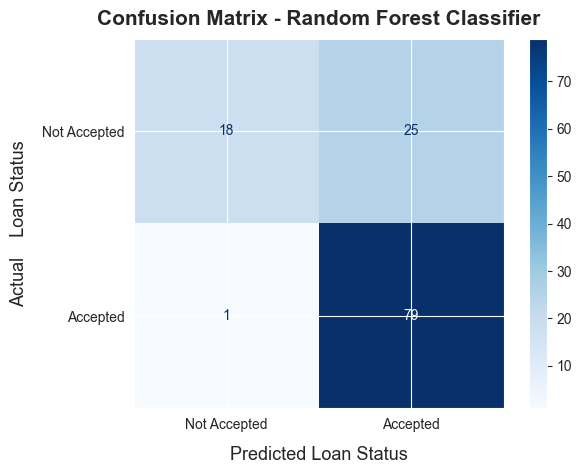

In [45]:
# Show the classification report
target_names = ['Not Accepted', 'Accepted']

print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, y_pred, target_names = target_names))

# Show the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)

plt.title('Confusion Matrix - Random Forest Classifier', pad = 10, size = 15, fontweight = 'bold')

plt.xlabel('Predicted Loan Status', labelpad = 10, size = 13)
plt.ylabel('Actual    Loan Status', labelpad = 10, size = 13)

plt.show()

## **Model Comparison**

In [46]:
compare_df = pd.DataFrame({
    'Model'               : ['Support Vector Machine', 'Random Forest Classifier'],
    'F1-Score Base Model' : [f'{100 * svm_testing_score:.2f}%'      , f'{100 * rf_testing_score:.2f}%'],
    'F1-Score Best Model' : [f'{100 * svm_testing_score_tuned:.2f}%', f'{100 * rf_testing_score_tuned:.2f}%']
}, index = [1, 2])

print('Model Comparison:')
compare_df

Model Comparison:


,Model,F1-Score Base Model,F1-Score Best Model
1,Support Vector Machine,85.87%,85.87%
2,Random Forest Classifier,84.92%,85.87%


# **Conclusion**

<p style="text-align: justify; font-family: 'Georgia', cursive, sans-serif; line-height: 1.5;">
Berdasarkan hasil evaluasi menggunakan <b>F1-Score</b>, <b>best model</b> dari <b>Support Vector Machine (SVM)</b> dan <b>Random Forest Classifier</b> menunjukkan nilai yang sama, yaitu <b>85.87%</b>. Namun, terdapat perbedaan dalam respons kedua model terhadap proses optimasi. <b>SVM tidak mengalami peningkatan performa</b>, di mana nilai F1-Score tetap sama sebelum dan sesudah tuning. Sebaliknya, <b>Random Forest mengalami peningkatan dari 84.92% menjadi 85.87%</b>, yang mengindikasikan bahwa proses tuning berdampak positif terhadap performa model. Meskipun peningkatan ini relatif kecil, hal ini menunjukkan bahwa <b>Random Forest lebih responsif terhadap optimasi dibandingkan SVM</b>. Oleh karena itu, dengan mempertimbangkan peningkatan performa setelah tuning, <b>Random Forest dapat dianggap sebagai model terbaik</b>.
</p>